# Decision trees - regression

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split

from feature_engine.selection import SelectBySingleFeaturePerformance

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns=["Latitude", "Longitude"])

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


### Visualize data

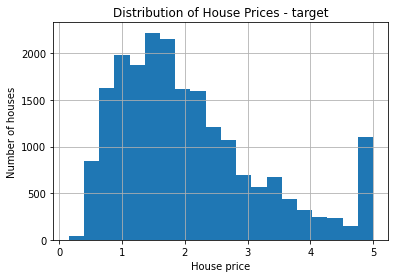

In [3]:
# Display the target distribution

y.hist(bins=20)
plt.xlabel("House price")
plt.ylabel("Number of houses")
plt.title("Distribution of House Prices - target")
plt.show()

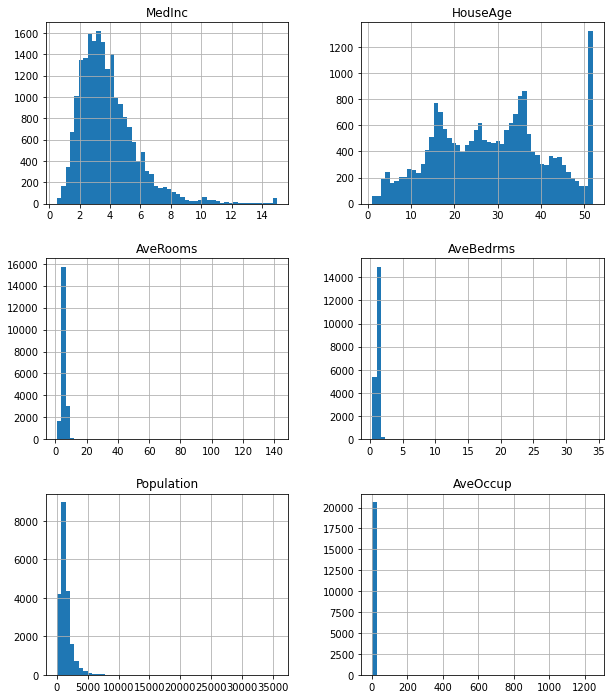

In [4]:
# Display the variables distribution

X.hist(bins=50, figsize=(10, 12))
plt.show()

### Split data

In [5]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((14448, 6), (6192, 6))

## Decision tree

In [6]:
# fit model

tree = DecisionTreeRegressor(
    criterion="squared_error",
    max_depth=3,
)

tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [7]:
# R2 in train set

tree.score(X_train, y_train)

0.5352201307625597

In [8]:
# R2 in test set

tree.score(X_test, y_test)

0.5005749951401735

The model explains about 50% of the variability in the target variable.

## Plot tree

This is how the tree makes the decisions.

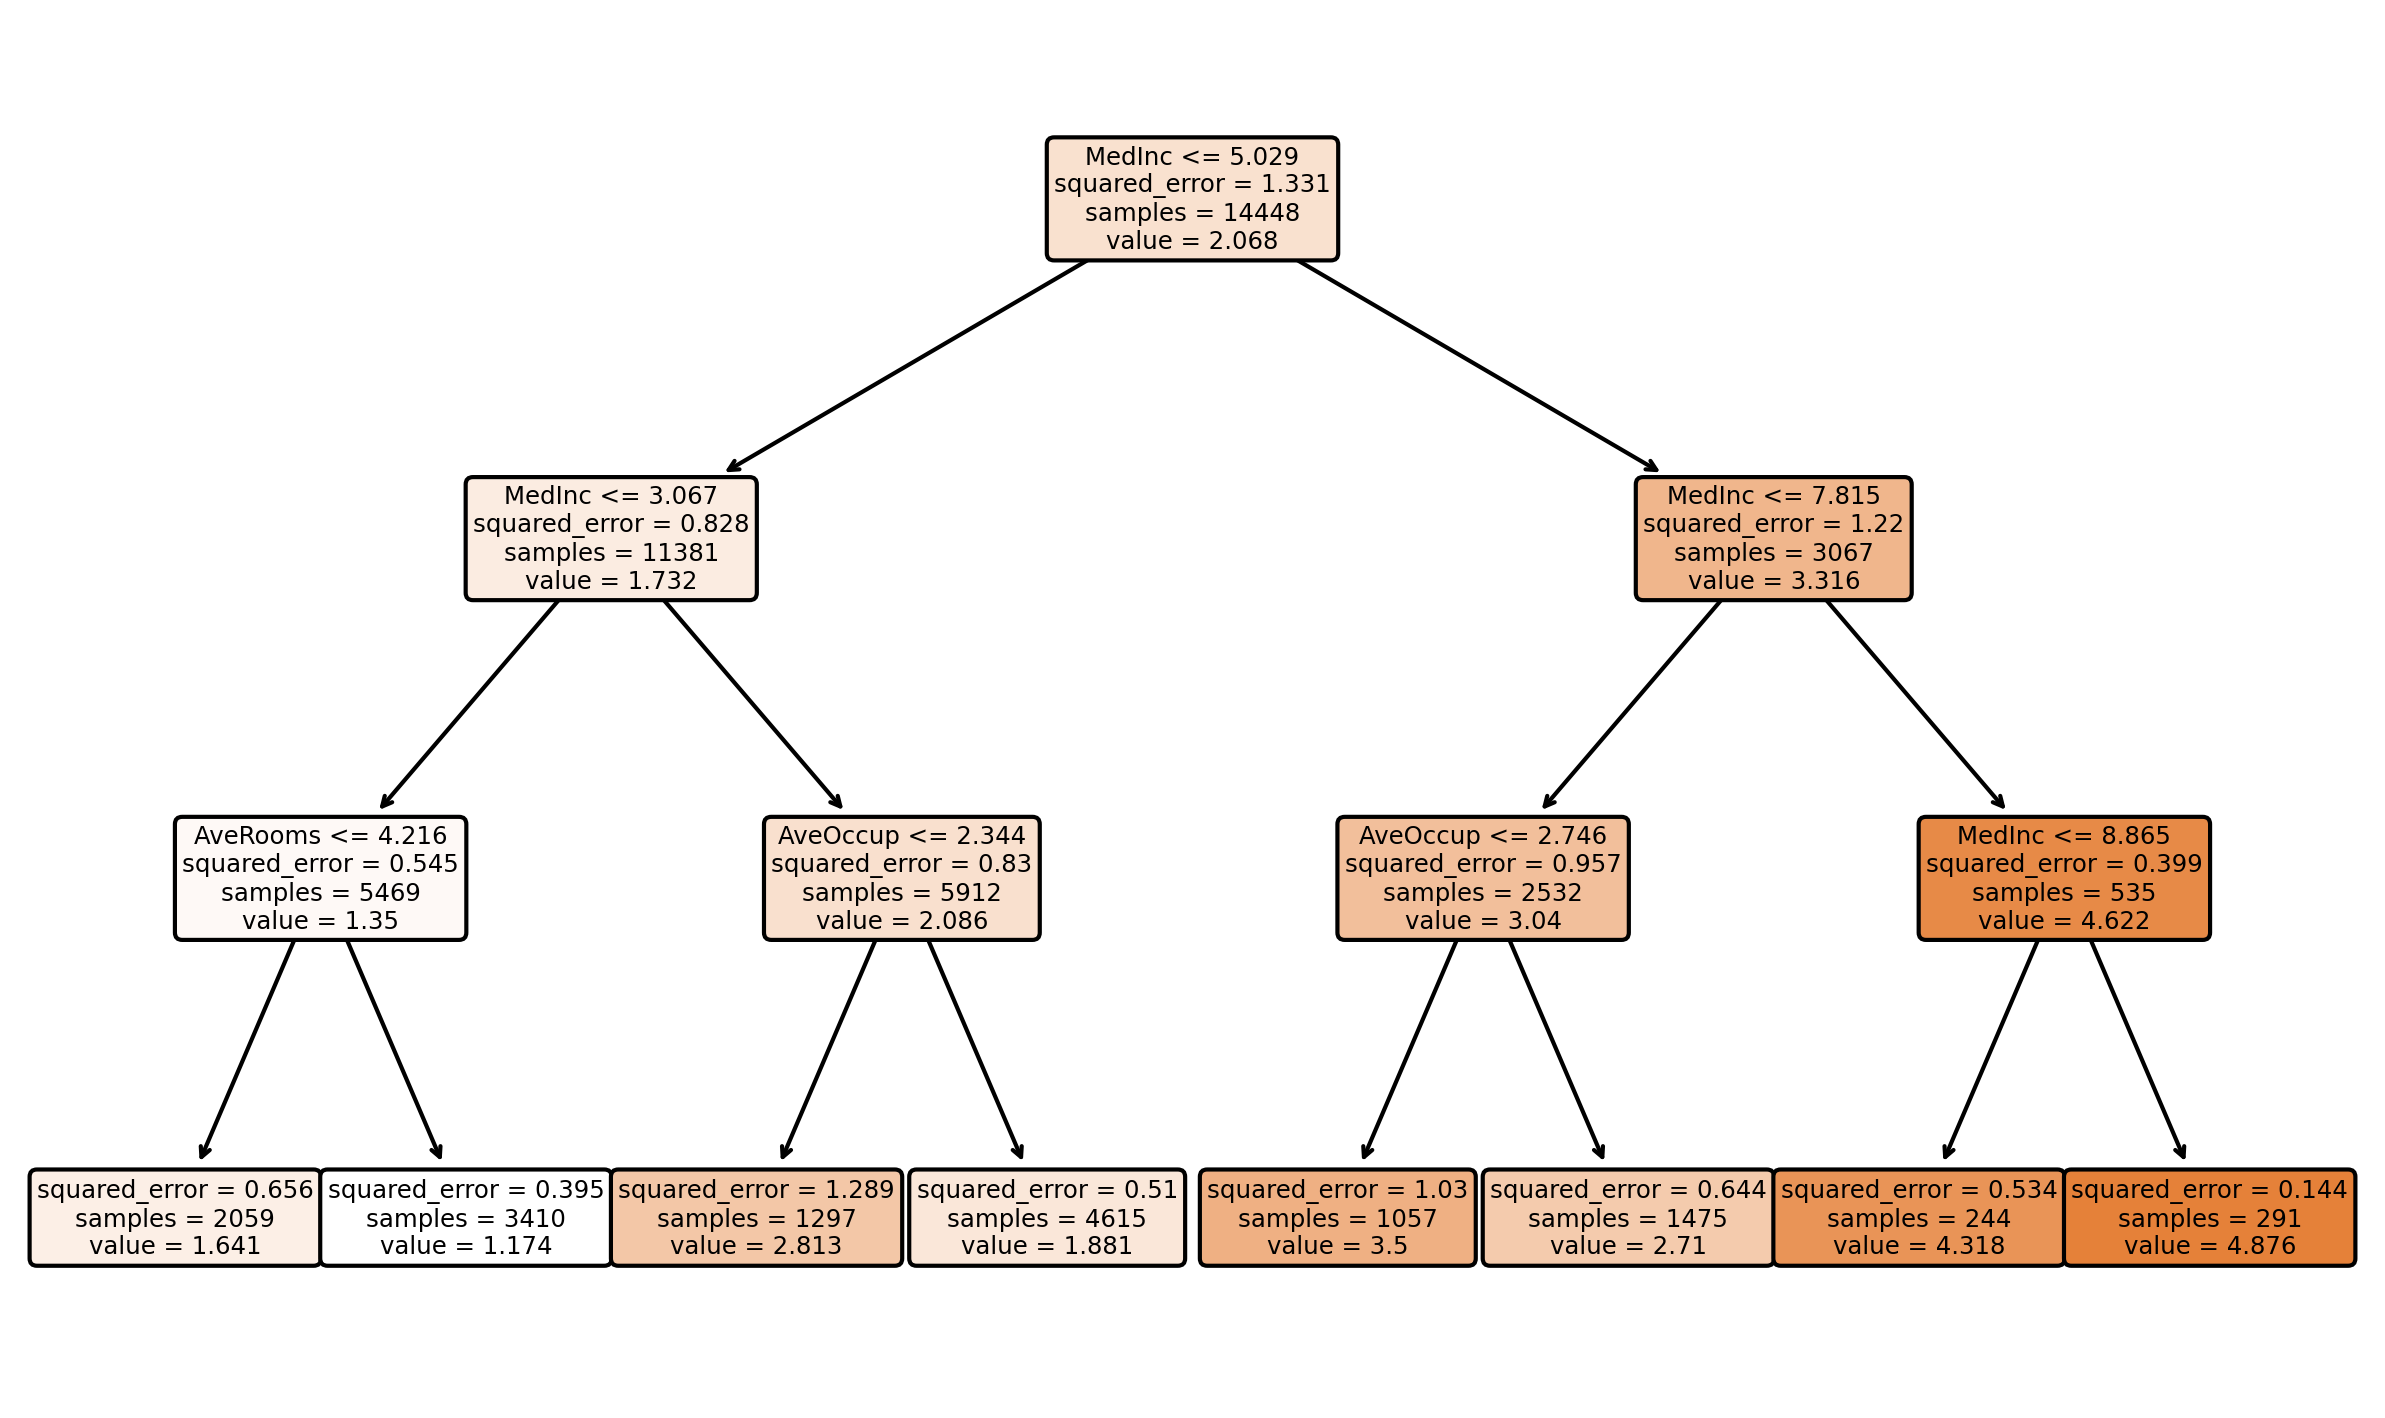

In [9]:
plt.figure(figsize=(10, 6), dpi=300)

plot_tree(
    decision_tree = tree,
    feature_names=X_train.columns.to_list(),
    filled=True, # color the squares
    rounded=True # round squares
)

plt.show()

**Note**

- The squared error decreases as we go down the nodes.
- The number of samples per node also decreases as we go along the nodes.
- Value is the mean of the target at each node
- Value in the leaves is the prediction of the decision tree.

The decision tree outputs discrete predictions.

## Global explanations - feature importance

Weighted decrease in impurity at each node contributed by each feature (normalized to 1, that is, the sum of the importances = 1)

https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d6e0a3e8ddf92a7e5561245224dab102/sklearn/tree/_tree.pyx#L1134-L1138

```
importances[node.feature] += (
    node.weighted_n_node_samples * node.impurity -
    left.weighted_n_node_samples * left.impurity -
    right.weighted_n_node_samples * right.impurity)
node += 1
```

In [10]:
# The sum of the importances = 1

pd.Series(tree.feature_importances_).sum()

1.0

In [11]:
global_exp = pd.Series(tree.feature_importances_, index=tree.feature_names_in_)

global_exp

MedInc        0.850004
HouseAge      0.000000
AveRooms      0.027279
AveBedrms     0.000000
Population    0.000000
AveOccup      0.122717
dtype: float64

As expected from the tree diagram, 2 of the features, Population and AveBdroms have 0 importance. And MedInc, which is used at the top of the tree and across many nodes, is the most important feature.

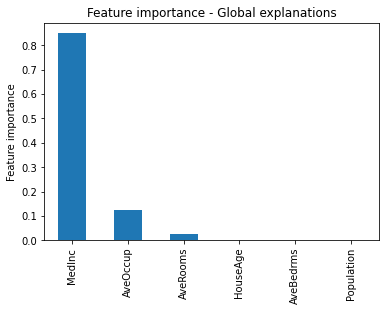

In [12]:
global_exp = pd.Series(tree.feature_importances_, index=tree.feature_names_in_)

global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

## Single feature regressors

Multi-colinearity and feature interaction will affect the importance shown by the trees, so to look at each feature individually, we can train single feature regressors.

In [13]:
sel = SelectBySingleFeaturePerformance(
    estimator = tree, 
    scoring='r2', 
    cv=3, 
    threshold=None,
)

sel.fit(X_train, y_train)

SelectBySingleFeaturePerformance(estimator=DecisionTreeRegressor(max_depth=3),
                                 scoring='r2')

Text(0.5, 1.0, 'Feature importance - Global explanations')

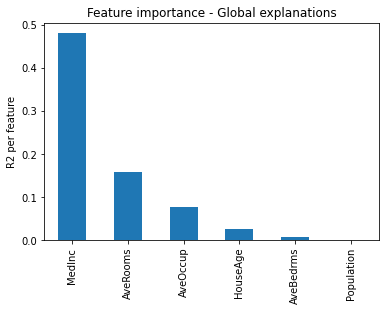

In [14]:
pd.Series(sel.feature_performance_).sort_values(ascending=False).plot.bar()
plt.ylabel("R2 per feature")
plt.title("Feature importance - Global explanations")

We can see how much of the price variability can be explained by each one of the features according to a decision tree.